In [1]:
suppressPackageStartupMessages({
  library(dataorganizer)
  library(data.table)
  library(ggplot2)
  library(dplyr)
  library(patchwork)

  devtools::load_all()
})

options(repr.matrix.max.cols=30, repr.matrix.max.rows=30)

ℹ Loading cellAdmixNotebooks


In [2]:
df <- prepare_gut_tx_and_meta()$df

# Count neighbours

In [3]:
dfc = df %>% group_by(cell, celltype) %>%
    summarise(x = median(x), y = median(y), z = median(z), .groups = 'drop')

xn = dfc %>% select(x, y, z) %>% FNN::get.knn(k = 8) %>% .$nn.index
ct_dict = dfc %>% mutate(id = 1:n()) %>% {setNames(.$celltype, .$id)}
cell_dict = dfc %>% mutate(id = 1:n()) %>% {setNames(.$cell, .$id)}

nmat = apply(xn, 2, function(i){ct_dict[i]})

ct_counts = nmat %>%
    reshape2::melt() %>%
    select(id = Var1, ct = value) %>%
    mutate(cell = cell_dict[id]) %>%
    select(-id) %>%
    as.data.table %>%
    mutate(ct = paste0('n_', ct)) %>%
    count(cell, ct, .drop = T) %>%
    dcast(cell ~ ct, value.var = 'n', fill = 0)

# Clustering

In [4]:
x = ct_counts %>% tibble::column_to_rownames('cell') %>% as.matrix
hc = hclust(dist(x))
clust_dict = cutree(hc, 4)

In [5]:
dfc$cluster = as.factor(clust_dict[dfc$cell])

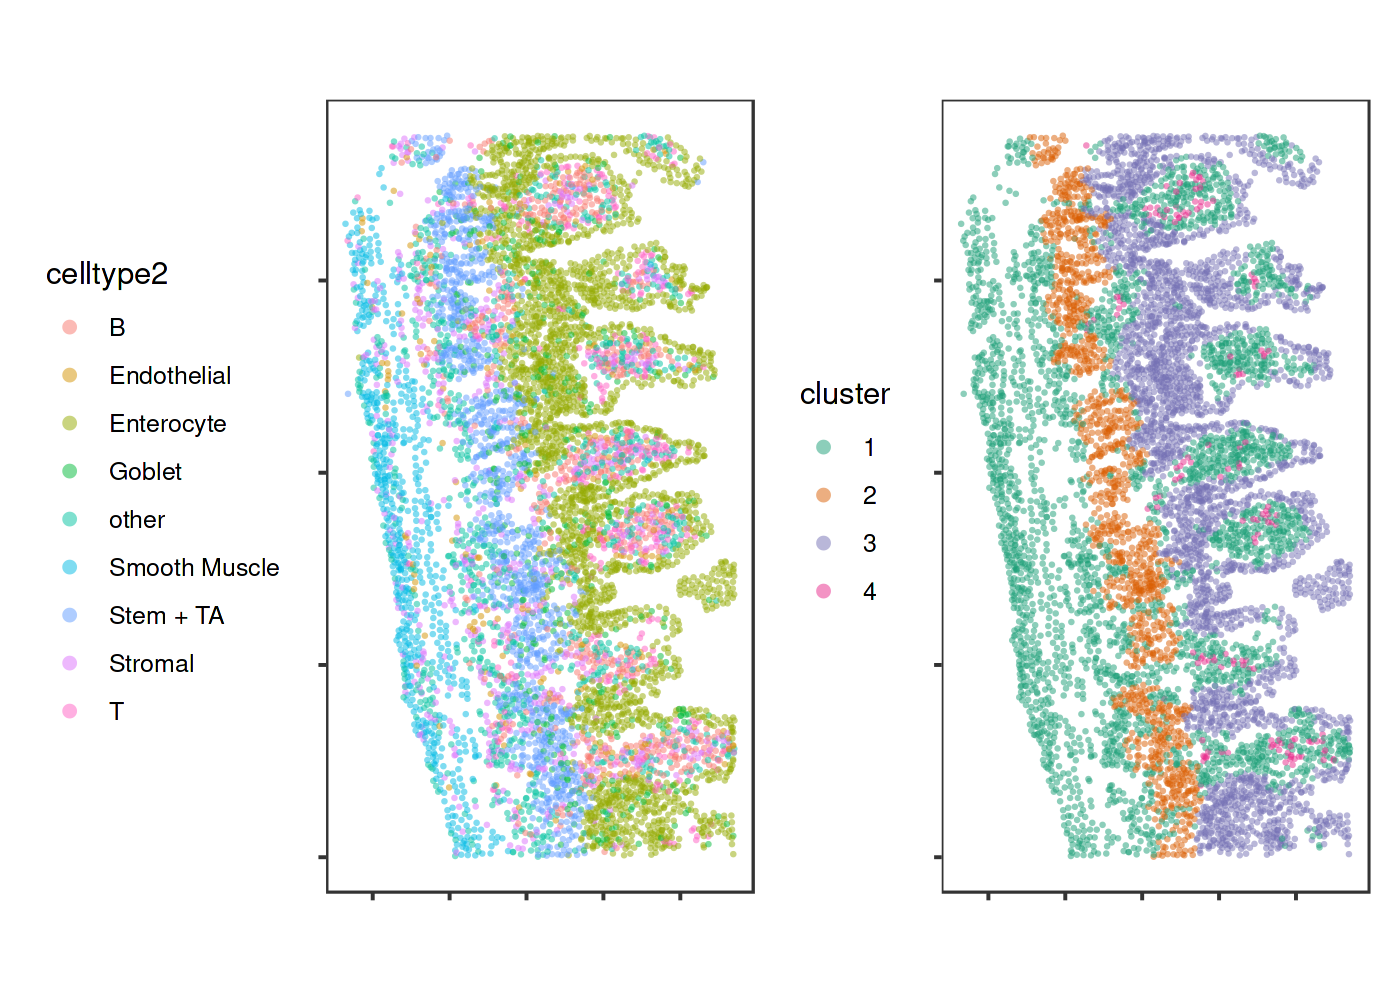

In [6]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)

p_cells = dfc %>%
    mutate(celltype2 = ifelse(
        celltype %in% c('B', 'T', 'Endothelial', 'Enterocyte', 'Goblet', 'Smooth Muscle', 'Stem + TA', 'Stromal'),
        celltype, 'other')) %>%
    ggplot(
        aes(x = x, y = y, color = celltype2)
    ) +
    geom_point(size = 0.6, alpha = 0.5, pch = 16) +
    # coord_fixed() +
    theme_bw() +
    guides(color = guide_legend(ncol = 1, override.aes = list(size = 2))) +
    theme(legend.position = 'left') +
    theme(
        axis.text = element_blank(),
        axis.title = element_blank(),
        panel.grid = element_blank()
    )

p_cluster = dfc %>%
    ggplot(
        aes(x = x, y = y, color = cluster)
    ) +
    geom_point(size = 0.6, alpha = 0.5, pch = 16) +
    theme_bw() +
    guides(color = guide_legend(ncol = 1, override.aes = list(size = 2))) +
    theme(legend.position = 'left') +
    theme(
        axis.text = element_blank(),
        axis.title = element_blank(),
        panel.grid = element_blank()
    ) +
    coord_fixed() +
    scale_color_manual(values = RColorBrewer::brewer.pal(name = 'Dark2', n = 5))

p_cells | p_cluster

In [7]:
DatasetPath('mouse_gut', 'gut_regions.rds') %>%
  saveRDS(clust_dict, .)